In [26]:
import numpy as np
import pandas as pd

def load_football():
    df = pd.read_csv('football.csv', delimiter=';')
    
    return df

In [27]:
df = load_football()
names = list(df.columns)

test = df[df["GoalsScored"].isna()]
train = df[~df["GoalsScored"].isna()]

In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X, y = train.drop(columns=["GoalsScored"]), train["GoalsScored"]
X = scaler.fit_transform(X)

# GLMs require intercept
X = np.hstack((np.ones((X.shape[0], 1)), X))    # (n_samples, n_features + 1)
y = y.to_numpy().flatten().astype(int)

In [29]:
train.isna().sum()  # Check for any remaining NaN values in the training set

X_ScoreRateH      0
X_ScoreRateA      0
X_ConcedeRateH    0
X_ConcedeRateA    0
X_CornerRatioH    0
X_CornerRatioA    0
X_FoulRatioH      0
X_FoulRatioA      0
GoalsScored       0
dtype: int64

Poisson GLM: \
p(Beta | y) = p(y | Beta) * p(Beta) \
Poisson = Poisson(Exp) * Normal 

In [30]:
X.shape, type(y), y.shape  # Check the shape of X and type of y

((1750, 9), numpy.ndarray, (1750,))

In [31]:
# https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/pymc_overview.html
import pymc as pm

# alpha + beta X
alpha = 5
with pm.Model(coords={"predictors": names[:-1]}) as model:
    _X = pm.Data("X", X)  
    _y = pm.Data("y", y)
    
    # Define the prior for alpha
    beta = pm.Normal("beta", mu=0, sigma=alpha, shape=X.shape[1])

    # Define the likelihood
    mu = pm.math.exp(pm.math.dot(_X, beta))   # lambda = exp(X @ beta) = log link
    y_obs = pm.Poisson("y_obs", mu=mu, observed=_y)  # Likelihood
    
    # Get inference data
    idata = pm.sample(1000, tune=1000, return_inferencedata=True, chains=5)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 4 jobs)
NUTS: [beta]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 20 seconds.


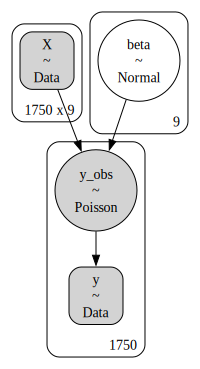

In [32]:
pm.model_to_graphviz(model)

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

In [34]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

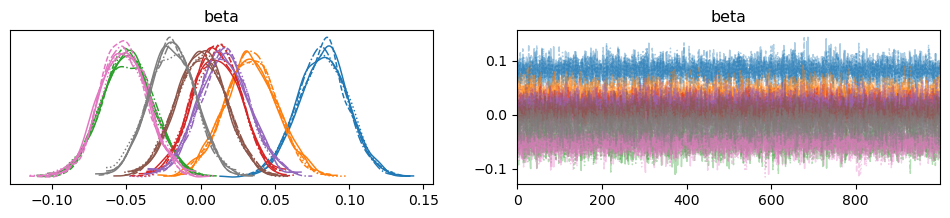

In [35]:
az.plot_trace(idata, coords={"beta_dim_0": list(range(1, 9))}, combined=False, var_names=["beta"])

In [43]:
names

['X_ScoreRateH',
 'X_ScoreRateA',
 'X_ConcedeRateH',
 'X_ConcedeRateA',
 'X_CornerRatioH',
 'X_CornerRatioA',
 'X_FoulRatioH',
 'X_FoulRatioA',
 'GoalsScored']

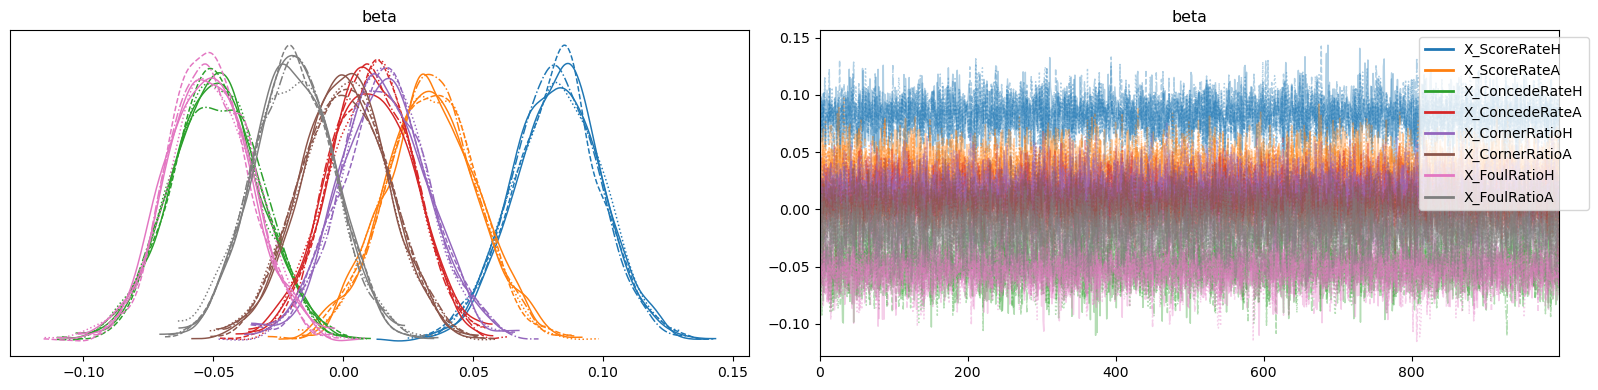

In [45]:
axes = az.plot_trace(idata, coords={"beta_dim_0": list(range(1, 9))}, combined=False, var_names=["beta"], figsize=(16, 4))
chain_colors = [line.get_color() for line in axes[0, 0].lines[::5]]  # Get colors from the first row
num_chains = len(chain_colors)
legend_labels = [f"{names[i]}" for i in range(num_chains)]

# Create custom legend handles
from matplotlib.lines import Line2D
handles = [Line2D([0], [0], color=color, lw=2) for color in chain_colors]

# Add legend to the entire figure
plt.legend(handles, legend_labels, loc='upper right', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

B > 0: feature increases predicted goals

In [68]:
mean_betas = np.mean(idata.posterior.beta.values, axis=(0, 1))  

In [77]:
_test = df[100:500].drop(columns=["GoalsScored"])
_test = scaler.transform(_test) 
_test = np.hstack((np.ones((_test.shape[0], 1)), _test)) 
predictions = np.exp(np.dot(_test, mean_betas))  

In [79]:
# Get MSE
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df["GoalsScored"][100:500], predictions)
print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 2.88


In [73]:
print(np.mean(predictions == df[100:500]["GoalsScored"].to_numpy().flatten().astype(int)))  # Accuracy of predictions

0.2275


In [75]:
with model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=123)

Sampling: [y_obs]


Output()

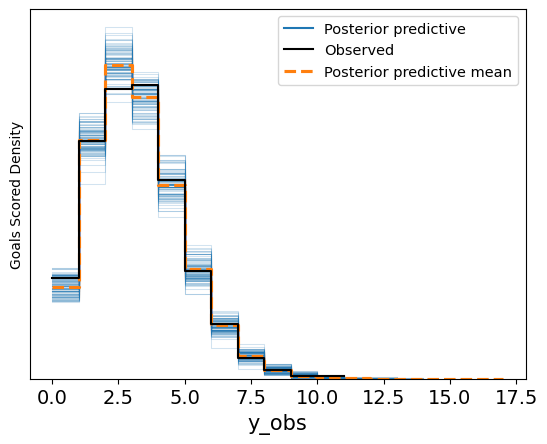

In [85]:
ax = az.plot_ppc(idata, num_pp_samples=100)
ax.set_ylabel("Goals Scored Density")
ax.tick_params(axis='y', which='both', labelleft=True, left=True)

ax.set_ylim(0, None)
ax.set_yticks(ax.get_yticks())  # Force showing ticks
plt.show()

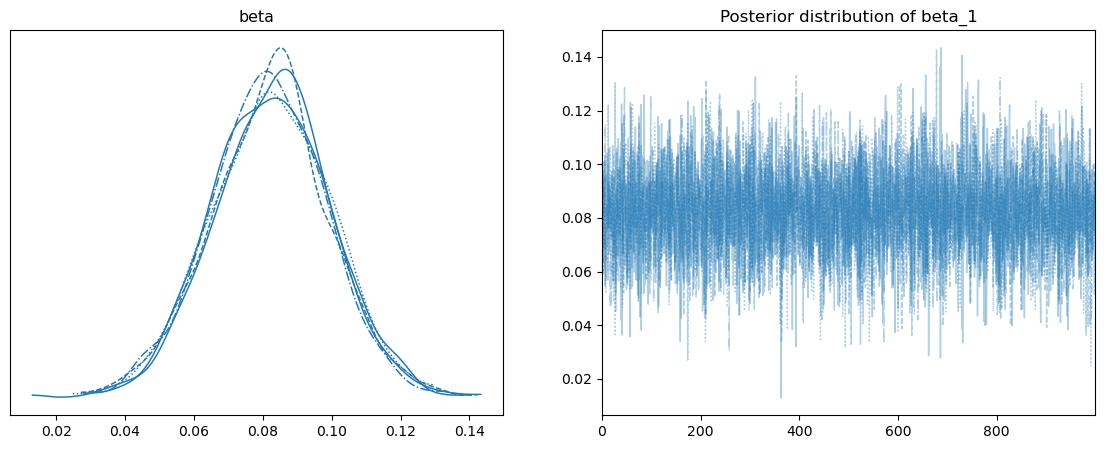

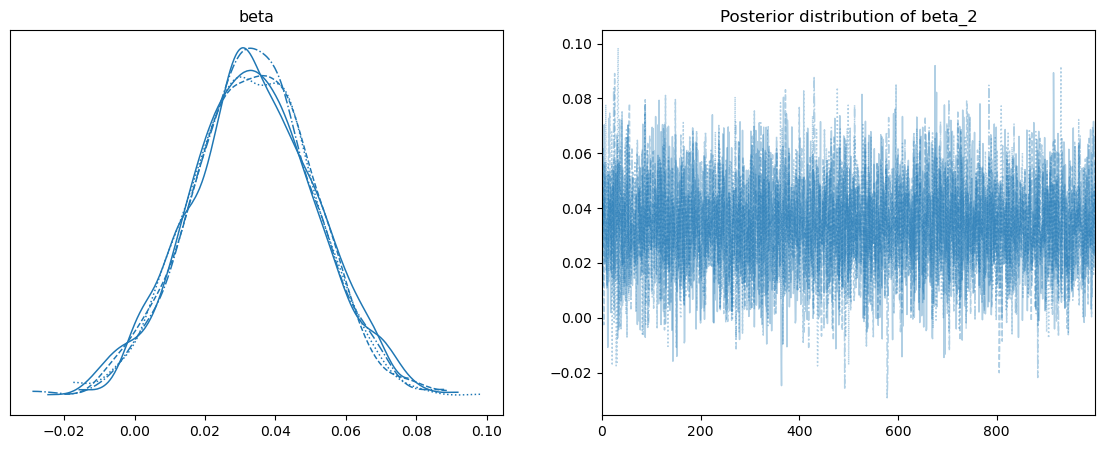

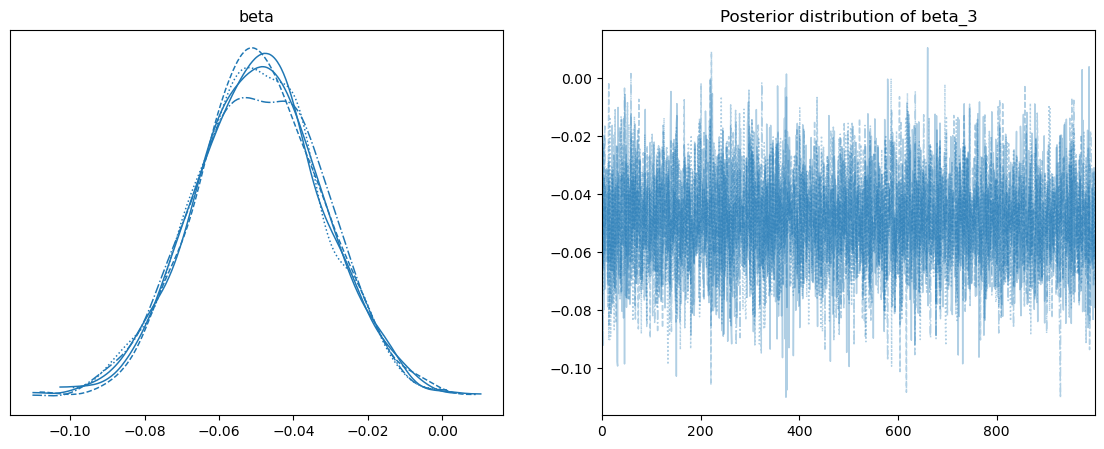

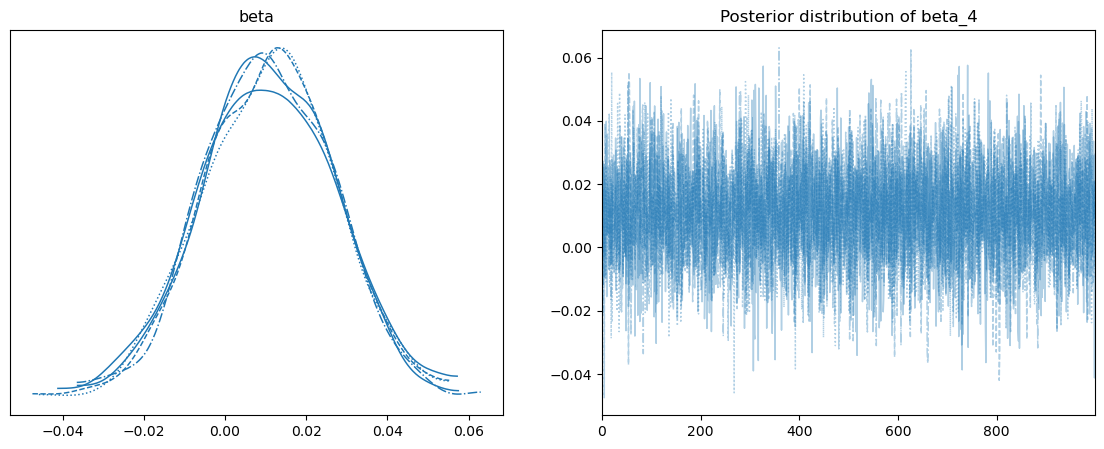

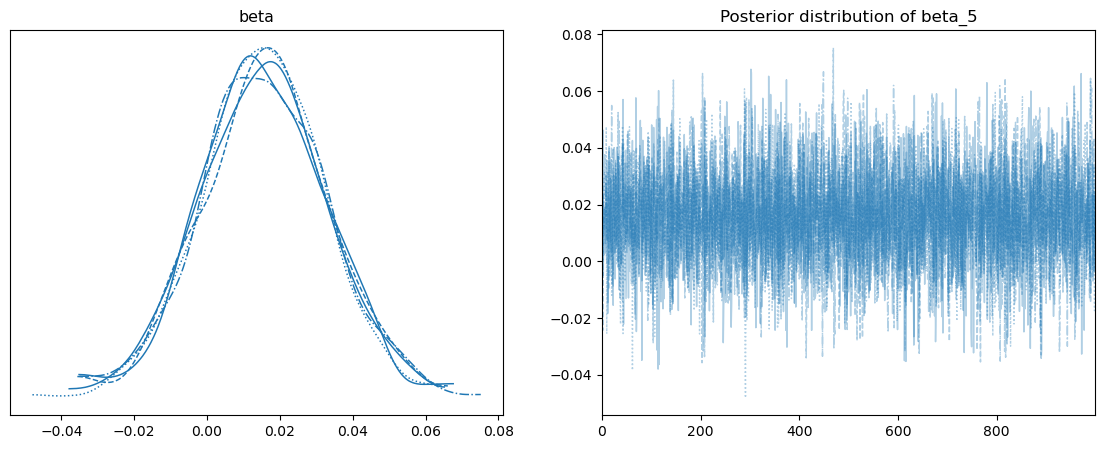

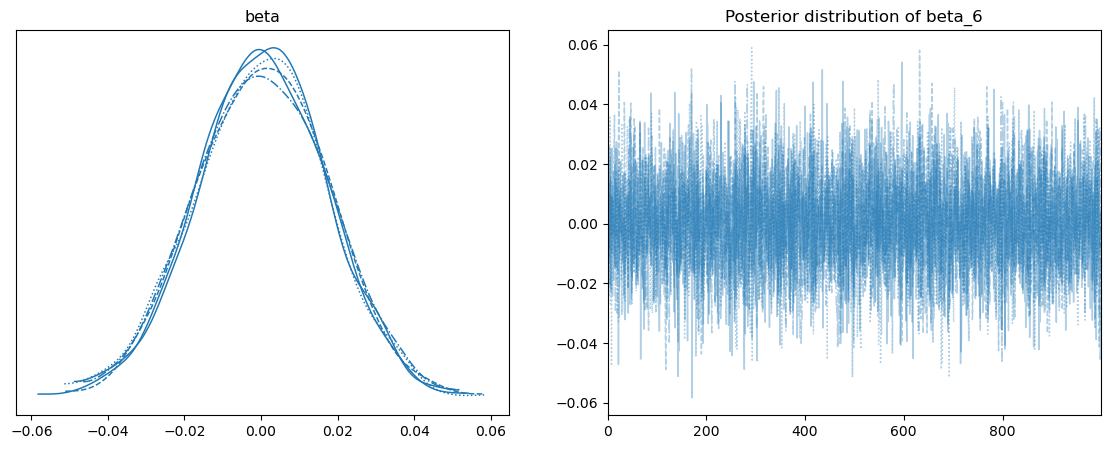

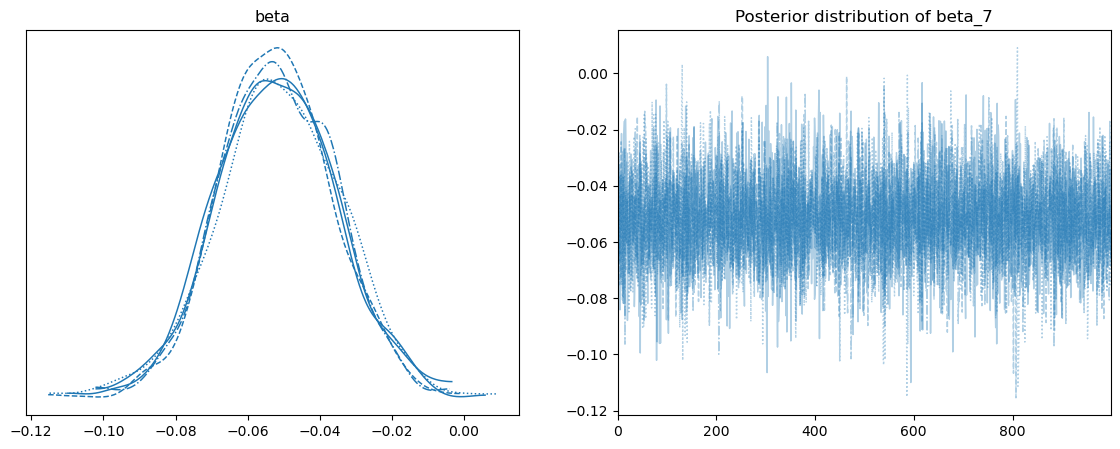

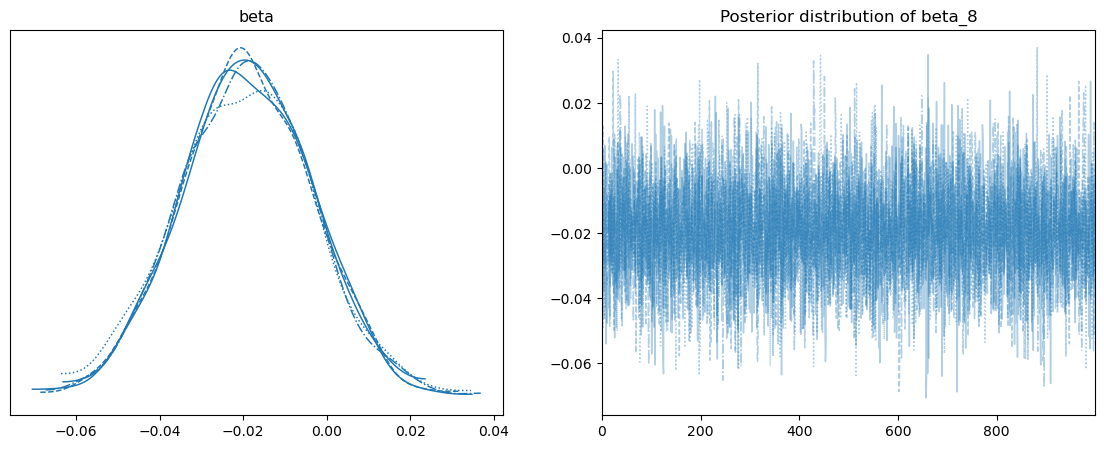

In [80]:
for i in range(1, 9):
    az.plot_trace(idata, coords={"beta_dim_0": i}, var_names=["beta"], figsize=(14, 5), combined=False)
    plt.title(f"Posterior distribution of beta_{i}")
    plt.show()

In [99]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.999,0.015,0.973,1.028,0.0,0.0,7692.0,3903.0,1.0
beta[1],0.082,0.017,0.051,0.114,0.0,0.0,7557.0,4066.0,1.0
beta[2],0.034,0.018,-0.001,0.065,0.0,0.0,6645.0,3894.0,1.0
beta[3],-0.049,0.017,-0.081,-0.017,0.0,0.0,6989.0,3957.0,1.0
beta[4],0.011,0.016,-0.020,0.039,0.0,0.0,7650.0,4105.0,1.0
beta[5],0.015,0.017,-0.016,0.046,0.0,0.0,7364.0,3848.0,1.0
beta[6],0.000,0.017,-0.031,0.032,0.0,0.0,7057.0,3237.0,1.0
beta[7],-0.052,0.016,-0.080,-0.021,0.0,0.0,7178.0,3875.0,1.0
beta[8],-0.019,0.016,-0.049,0.011,0.0,0.0,8039.0,4085.0,1.0


In [ ]:
az.summary(idata)["ess_bulk"].mean()  # Effective sample size for bulk of the posterior


np.float64(7565.111111111111)

<Axes: >

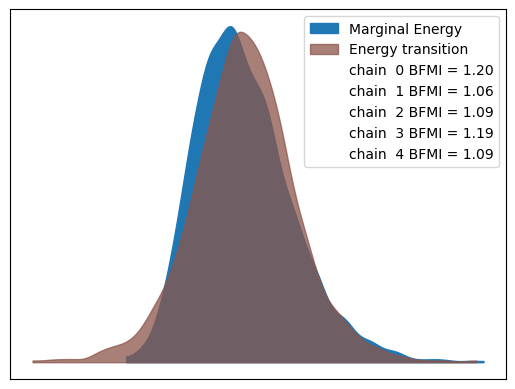

In [100]:
az.plot_energy(idata)

(-0.1, 0.1)

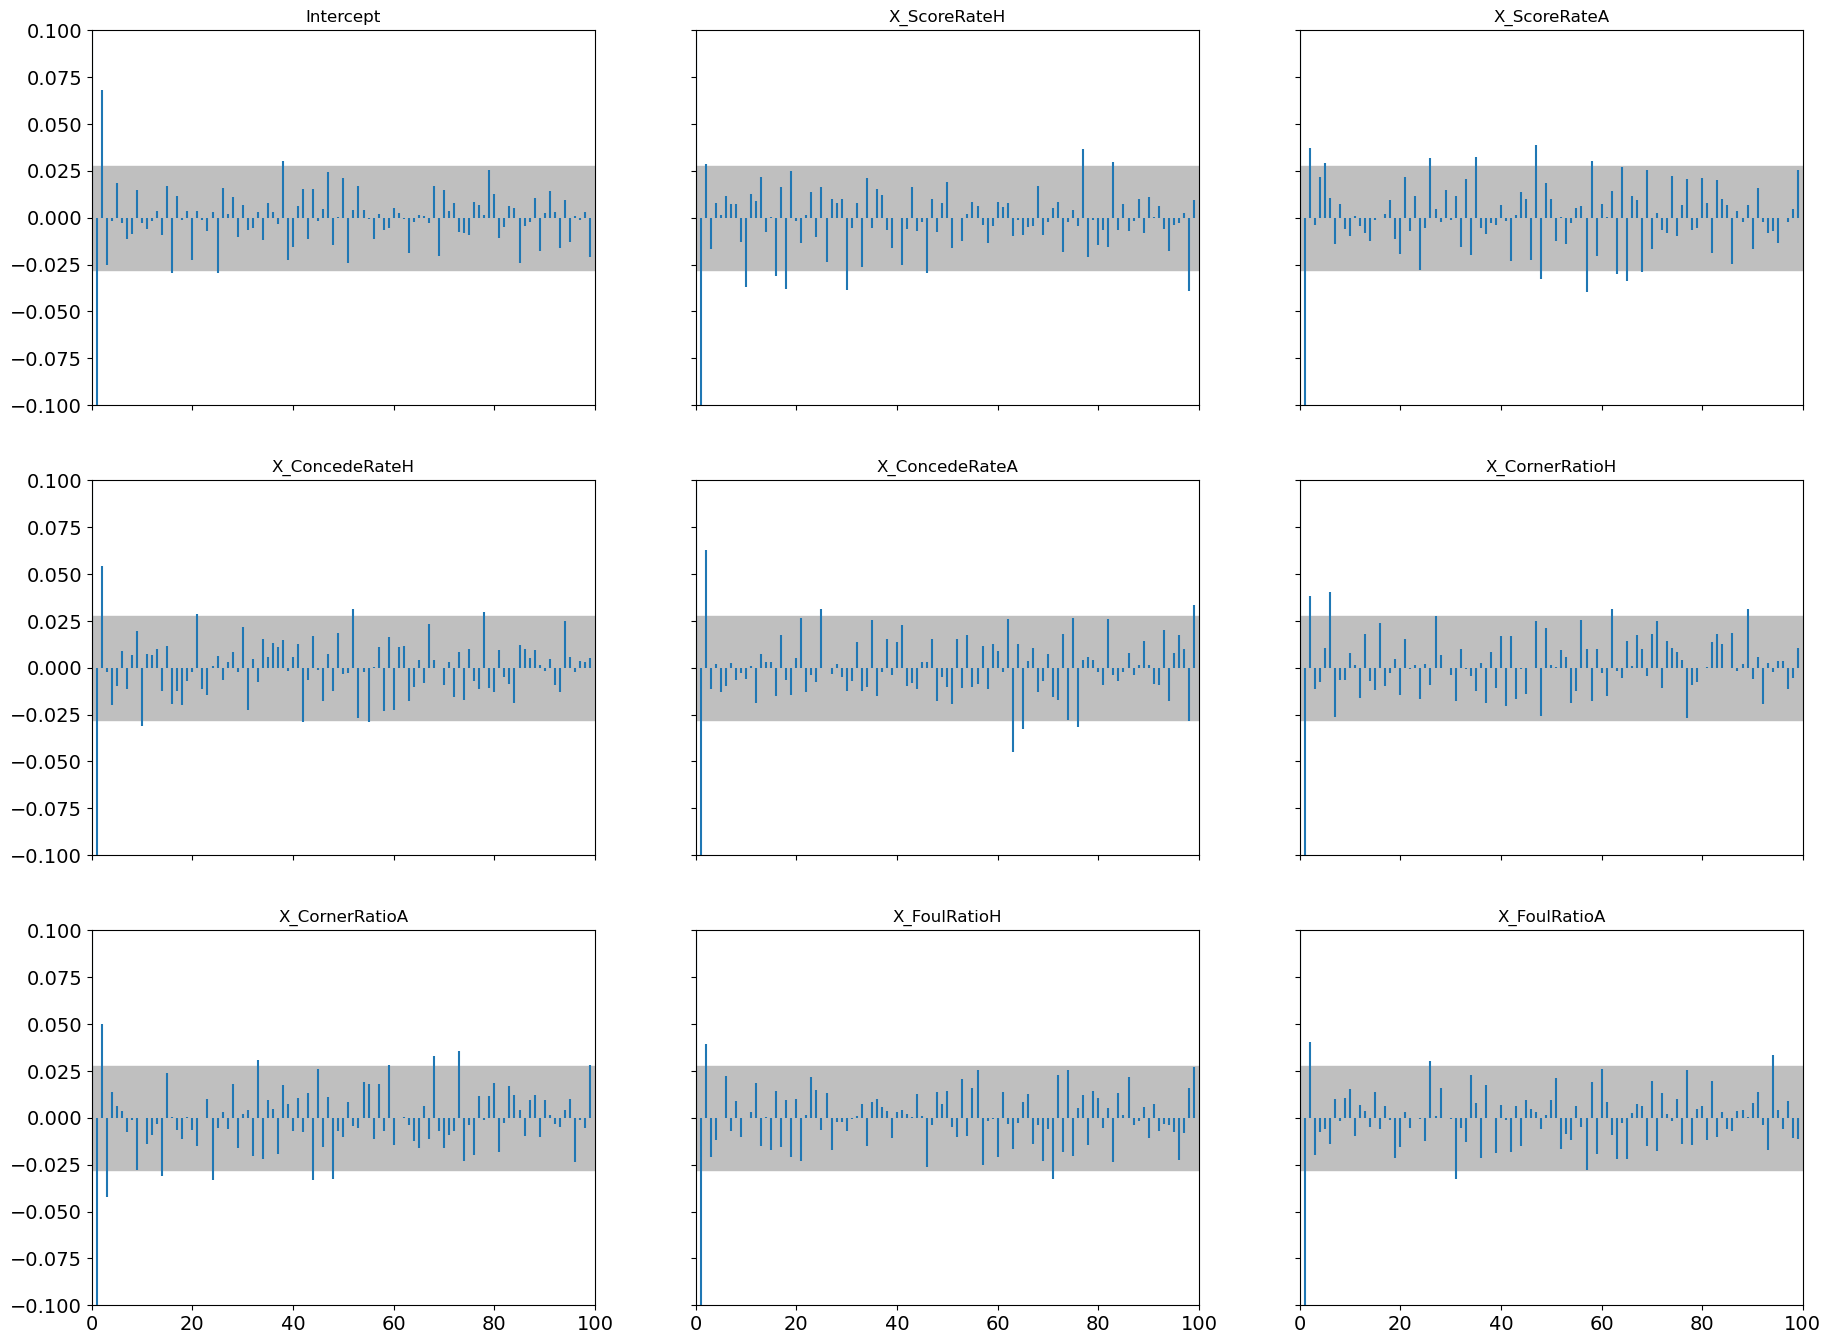

In [25]:
ax = az.plot_autocorr(idata, var_names=["beta"], combined=True)
ax = ax.flatten()
for i in range(9):
    ax[i].set_title(names[i-1])
    if i == 0:
        ax[i].set_title("Intercept")
plt.ylim(-0.1, 0.1)

array([[<Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n1'}>,
        <Axes: title={'center': 'beta\n2'}>],
       [<Axes: title={'center': 'beta\n3'}>,
        <Axes: title={'center': 'beta\n4'}>,
        <Axes: title={'center': 'beta\n5'}>],
       [<Axes: title={'center': 'beta\n6'}>,
        <Axes: title={'center': 'beta\n7'}>,
        <Axes: title={'center': 'beta\n8'}>]], dtype=object)

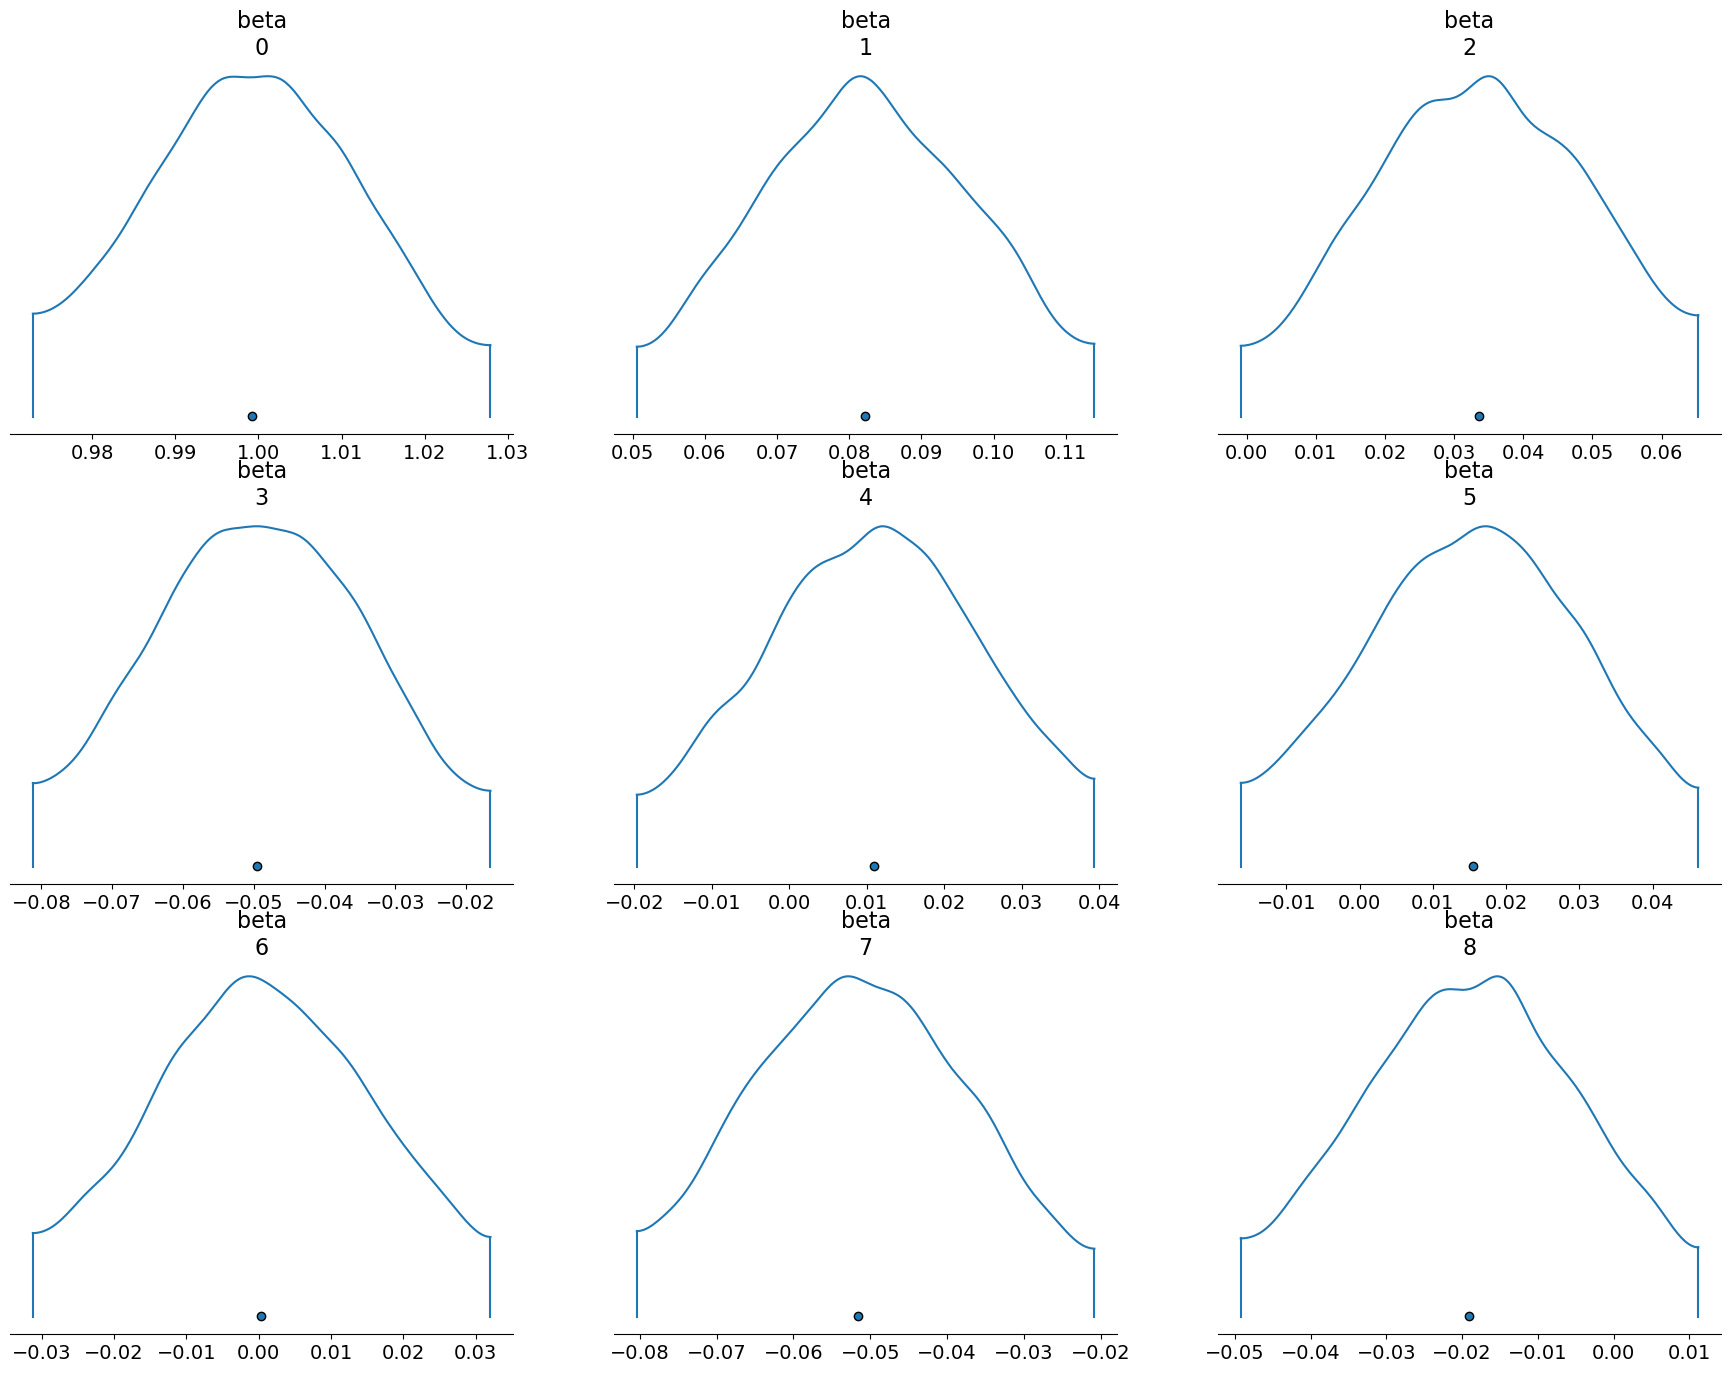

In [102]:
az.plot_density(idata, var_names=["beta"])

# Part 2

In [153]:
from scipy.optimize import minimize # We need to maximize, multiply by -1

def log_posterior(beta, X, y, alpha=alpha):
    return - (y @ (X @ beta) - np.sum(np.exp(X @ beta)) - (.5 / alpha) * np.sum(beta**2))

def grad(beta, X, y, alpha=alpha):
    return - (X.T @ y - X.T @ np.exp(X @ beta) - 1 / alpha * beta)

def hessian(beta, X, y, alpha=alpha):
    return X.T @ (np.diag(np.exp(X @ beta))) @ X + (1 / alpha) * np.eye(X.shape[1])


beta_init = np.zeros(X.shape[1])
result = minimize(
    fun=log_posterior,
    x0=beta_init,
    args=(X, y, alpha),
    method='Newton-CG',
    jac=grad,
    hess=hessian
)

In [154]:
mean_beta = result.x
mean_beta   # We got mu, need standard deviation for each beta

array([ 9.99978598e-01,  8.25836696e-02,  3.38643881e-02, -4.91814280e-02,
        1.10115473e-02,  1.51989728e-02,  2.77957088e-04, -5.16711829e-02,
       -1.92648329e-02])

f(w) = f(z) + (w - z).T * grad(f(z)) + 0.5 * (w - z).T * hessian(f(z)) * (w - z)

In [155]:
# Laplace approximation
hess = hessian(mean_beta, X, y, alpha)
S = np.linalg.inv(hess)  # Covariance matrix

In [164]:
betas_final = []
# mean_beta = mean_beta[1:]  # Exclude intercept  -- dont, you need it later
for i, mbeta in enumerate(mean_beta):
    if i == 0:
        continue
    print(S[i, i])
    sd = np.sqrt(S[i, i])
    
    x_range = 4 * sd    # Range for plotting - get all values within 5 standard deviations - 4 for visualization
    x_val = np.linspace(mbeta - x_range, mbeta + x_range, 100)
    pdf = (1 / (sd * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_val - mbeta) / sd) ** 2)  # Normal pdf
    
    betas_final.append((x_val, pdf))

0.00028136941307898357
0.0003193983627531839
0.00029000063768834744
0.00026117271906344187
0.0002893294200028059
0.0002992167007498516
0.00025536223418979904
0.00025839097361906005


In [165]:
betas_final

[(array([0.01548739, 0.01684287, 0.01819835, 0.01955383, 0.02090931,
         0.02226479, 0.02362027, 0.02497575, 0.02633123, 0.02768671,
         0.02904219, 0.03039768, 0.03175316, 0.03310864, 0.03446412,
         0.0358196 , 0.03717508, 0.03853056, 0.03988604, 0.04124152,
         0.042597  , 0.04395248, 0.04530796, 0.04666344, 0.04801892,
         0.0493744 , 0.05072988, 0.05208536, 0.05344084, 0.05479632,
         0.0561518 , 0.05750728, 0.05886276, 0.06021824, 0.06157372,
         0.0629292 , 0.06428468, 0.06564016, 0.06699565, 0.06835113,
         0.06970661, 0.07106209, 0.07241757, 0.07377305, 0.07512853,
         0.07648401, 0.07783949, 0.07919497, 0.08055045, 0.08190593,
         0.08326141, 0.08461689, 0.08597237, 0.08732785, 0.08868333,
         0.09003881, 0.09139429, 0.09274977, 0.09410525, 0.09546073,
         0.09681621, 0.09817169, 0.09952717, 0.10088265, 0.10223814,
         0.10359362, 0.1049491 , 0.10630458, 0.10766006, 0.10901554,
         0.11037102, 0.1117265 , 0

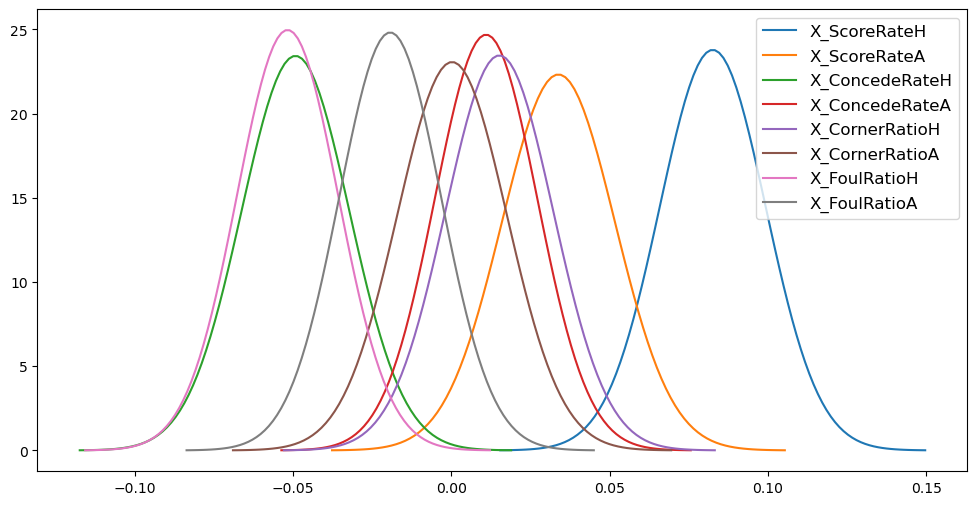

In [170]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, (x_val, pdf) in enumerate(betas_final):
    plt.plot(x_val, pdf, label=f"{names[i]}")
plt.legend(fontsize=12)

### Test predictions

In [167]:
# Prepare data
X_test = scaler.fit_transform(test.drop(columns=["GoalsScored"]))
X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))  # intercept

In [168]:
beta_samples = np.random.multivariate_normal(mean_beta, S, size=1000)
pred_samples = np.exp(X_test @ beta_samples.T)  # Predictions for each sample

# point estimates
# MSE
mse_pred = np.mean(pred_samples, axis=1)

# Abs error
abs_pred = np.median(pred_samples, axis=1)

# Accuracy
from scipy.stats import mode
acc_pred = np.round(mode(pred_samples, axis=1).mode.flatten()).astype(int)

In [169]:
mse_pred, abs_pred, acc_pred

(array([2.68623566, 2.60269072, 2.41331628, 2.94651727, 2.67363149,
        3.52326145, 2.36029029, 2.54822561, 2.611579  , 2.76016384,
        3.9870047 , 2.46731978, 3.00770986, 2.53239571, 2.20952415,
        2.58871113, 2.58766685, 2.52322331, 2.77344672, 2.4337905 ,
        2.10234843, 3.08245068, 2.53292947, 2.26995244, 2.61750299,
        3.86440215, 4.3243735 , 3.15011688, 2.91441835, 2.5572079 ,
        2.57322723, 2.71196055, 3.85698296, 2.49081395, 2.99836481,
        2.33584028, 3.26593179, 2.39953296, 2.46875432, 2.57596268,
        2.7503645 , 2.75574712, 2.59129996, 2.62002023, 4.22723475,
        2.69272654, 2.42924669, 2.41709889, 2.42786727, 2.40579794,
        2.19857608, 2.41639051, 2.67005821, 3.30856789, 2.67060115,
        2.98246494, 2.84395089, 3.0487096 , 2.81742177, 2.87177231,
        2.44277555, 1.9511699 , 2.52778346, 2.78776262, 2.91537165,
        2.50327544, 2.36201539, 2.20233905, 2.33130546, 2.42341924,
        2.7313729 , 2.49834191, 3.75848962, 2.20

In [ ]:
len([i for i in acc_pred if i == 2])


72

(array([72.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 26.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2,
        3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. ]),
 <BarContainer object of 20 artists>)

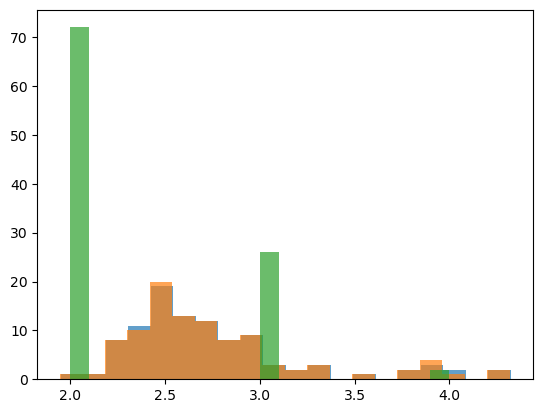

In [ ]:
fig, ax1 = plt.subplots()

# Plot histograms on primary y-axis
ax1.hist(mse_pred, bins=20, alpha=0.7, label='mse_pred')
ax1.hist(abs_pred, bins=20, alpha=0.7, label='abs_pred')
ax1.hist(acc_pred, bins=20, alpha=0.7, label='acc_pred')

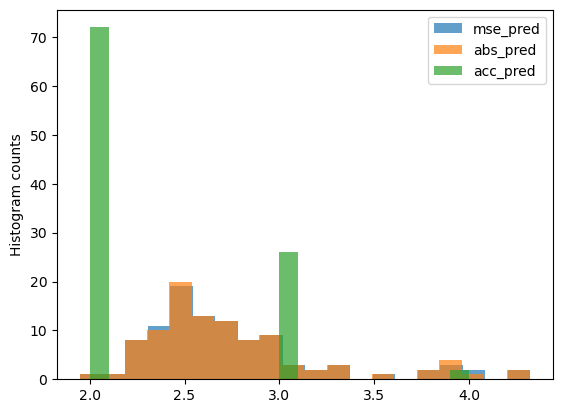

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

# Plot histograms on primary y-axis
ax1.hist(mse_pred, bins=20, alpha=0.7, label='mse_pred')
ax1.hist(abs_pred, bins=20, alpha=0.7, label='abs_pred')
ax1.hist(acc_pred, bins=20, alpha=0.7, label='acc_pred')
ax1.set_ylabel('Histogram counts')
ax1.legend(loc='upper right')

ppc_vals = idata.posterior_predictive.y_obs.values.flatten()

plt.show()
